## imports

In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import seaborn as sns

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
gc.collect()

0

In [4]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True

## load model chains and pre-computed velocity dispersion

In [5]:
import sys
sys.path.insert(0, './process_output')

from output_class import *

In [6]:
dir_prefix = '../temp/'
dir_suffix = '_out.txt'

save_fig = False # if True, will overwrite figures in the paper

In [7]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [8]:
composite_files = [
#     '2038_run145_1_0_0_0_0_shortened',
#     '2038_run145_1_0_1_0_0_shortened',
#     '2038_run145_1_0_2_0_0_shortened',
#     '2038_run145_1_1_0_0_0_shortened',
#     '2038_run145_1_1_1_0_0_shortened',
#     '2038_run145_1_1_2_0_0_shortened',
    
#     '2038_run146_1_0_0_0_0_shortened',
#     '2038_run146_1_0_1_0_0_shortened',
#     '2038_run146_1_0_2_0_0_shortened',
#     '2038_run146_1_1_0_0_0_shortened',
#     '2038_run146_1_1_1_0_0_shortened',
#     '2038_run146_1_1_2_0_0_shortened',
    
    '2038_run205_1_0_0_0_0_shortened',
    '2038_run205_1_0_1_0_0_shortened',
    '2038_run205_1_0_2_0_0_shortened',
    '2038_run205_1_1_0_0_0_shortened',
    '2038_run205_1_1_1_0_0_shortened',
    '2038_run205_1_1_2_0_0_shortened',
    
    '2038_run206_1_0_0_0_0_shortened',
    '2038_run206_1_0_1_0_0_shortened',
    '2038_run206_1_0_2_0_0_shortened',
    '2038_run206_1_1_0_0_0_shortened',
    '2038_run206_1_1_1_0_0_shortened',
    '2038_run206_1_1_2_0_0_shortened',
    
#     '2038_run178_1_0_0_0_0_shortened',
#     '2038_run178_1_0_1_0_0_shortened',
#     '2038_run178_1_0_2_0_0_shortened',
#     '2038_run178_1_1_0_0_0_shortened',
#     '2038_run178_1_1_1_0_0_shortened',
#     '2038_run178_1_1_2_0_0_shortened',
    
#     '2038_run179_1_0_0_0_0_shortened',
#     '2038_run179_1_0_1_0_0_shortened',
#     '2038_run179_1_0_2_0_0_shortened',
#     '2038_run179_1_1_0_0_0_shortened',
#     '2038_run179_1_1_1_0_0_shortened',
#     '2038_run179_1_1_2_0_0_shortened',
]

# def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
#                                  kwargs_lens_light=None, kwargs_ps=None, 
#                                  kwargs_special=None, kwargs_extinction=None):
#     """
#     Impose a Gaussian prior on the NFW scale radius R_s based on Gavazzi et al. (2007).
#     """
#     # imports inside function to avoid pickling 
#     from colossus.halo import concentration
#     from colossus.halo import mass_defs
#     from colossus.cosmology import cosmology
    
#     from lenstronomy.Cosmo.lens_cosmo import LensCosmo
#     from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
#     from lenstronomy.LensModel.lens_model import LensModel


#     lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)
#     lens_analysis = LensProfileAnalysis(
#                             LensModel(lens_model_list=['NFW_ELLIPSE', 'SHEAR', 'TRIPLE_CHAMELEON'],
#                             z_lens=0.230, z_source=0.777,
#                             multi_plane=False, #True,
#                             ))


#     if kwargs_lens[0]['alpha_Rs'] < 0.:
#         return -np.inf
    
#     if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
#         return -np.inf
#     if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
#         return -np.inf
    
#     if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
#         return -np.inf
#     if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
#         return -np.inf
    
#     log_L = 0.
    
#     # integrate upto 3.2 arcsec, which is half-light radius (~half-mass radius)
#     mean_convergence = lens_analysis.mass_fraction_within_radius(kwargs_lens, 
#                                                              kwargs_lens[2]['center_x'], 
#                                                              kwargs_lens[2]['center_y'], 
#                                                              3.2,
#                                                              numPix=320)
    
#     stellar_mass = np.log10(mean_convergence[2] * np.pi * (3.2/206265 * lens_cosmo.dd)**2 
#                             * lens_cosmo.sigma_crit * 2) # multiplying by 2 to convert half-mass to full mass
    
#     #log_L += - 0.5 * (stellar_mass - 11.40)**2 / (0.08**2 + 0.1**2)
#     # adding 0.07 uncertainty in quadrature to account for 15% uncertainty in H_0, Om_0 ~ U(0.05, 0.5)
#     high_sm = 11.57 + 0.25 + 0.06 # +0.06 is to add H_0 uncertainty
#     low_sm = 11.57 - 0.06 # -0.06 is to add H_0 uncertainty
#     if stellar_mass > high_sm:
#         log_L += -0.5 * (high_sm - stellar_mass)**2 / (0.16**2)
#     elif stellar_mass < low_sm:
#         log_L += -0.5 * (low_sm - stellar_mass)**2 / (0.13**2)
#     else:
#         log_L += 0.
        
#     _, _, c, r, halo_mass = lens_cosmo.nfw_angle2physical(kwargs_lens[0]['Rs'], kwargs_lens[0]['alpha_Rs'])
#     log_L += -0.5 * (np.log10(halo_mass) - 13.5)**2 / 0.3**2
    
#     my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 
#                 'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
#     cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

#     c200 = concentration.concentration(halo_mass*cosmo.h, '200c', # input halo mass needs to be in M_sun/h unit
#                                        0.23, model='diemer19')
    
#     log_L += -0.5 * (np.log10(c) - np.log10(c200))**2 / (0.11**2)
            
#     return log_L

def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None):
    """
    Impose a Gaussian prior on the NFW scale radius R_s based on Gavazzi et al. (2007).
    """
    # imports inside function to avoid pickling 
    from colossus.halo import concentration
    from colossus.halo import mass_defs
    from colossus.cosmology import cosmology
    
    from lenstronomy.Cosmo.lens_cosmo import LensCosmo
    from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
    from lenstronomy.LensModel.lens_model import LensModel


    lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)
    lens_analysis = LensProfileAnalysis(
                            LensModel(lens_model_list=['NFW_ELLIPSE', 'SHEAR', 'TRIPLE_CHAMELEON'],
                            z_lens=0.230, z_source=0.777,
                            multi_plane=False, #True,
                            ))


    if kwargs_lens[0]['alpha_Rs'] < 0.:
        return -np.inf
    
    if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
        return -np.inf
    if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
        return -np.inf
    
    if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
        return -np.inf
    if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
        return -np.inf
    
    log_L = 0.
    
    log_L += -0.5 * (kwargs_lens[0]['Rs'] - 22.6)**2 / 3.1**2
    
    # integrate upto 3.2 arcsec, which is half-light radius (~half-mass radius)
#     mean_convergence = lens_analysis.mass_fraction_within_radius(kwargs_lens, 
#                                                              kwargs_lens[2]['center_x'], 
#                                                              kwargs_lens[2]['center_y'], 
#                                                              3.2,
#                                                              numPix=320)
    
#     stellar_mass = np.log10(mean_convergence[2] * np.pi * (3.2/206265 * lens_cosmo.dd)**2 
#                             * lens_cosmo.sigma_crit * 2) # multiplying by 2 to convert half-mass to full mass
    
    #log_L += - 0.5 * (stellar_mass - 11.40)**2 / (0.08**2 + 0.1**2)
    # adding 0.07 uncertainty in quadrature to account for 15% uncertainty in H_0, Om_0 ~ U(0.05, 0.5)
#     high_sm = 11.57 + 0.25 + 0.06 # +0.06 is to add H_0 uncertainty
#     low_sm = 11.57 - 0.06 # -0.06 is to add H_0 uncertainty
#     if stellar_mass > high_sm:
#         log_L += -0.5 * (high_sm - stellar_mass)**2 / (0.16**2)
#     elif stellar_mass < low_sm:
#         log_L += -0.5 * (low_sm - stellar_mass)**2 / (0.13**2)
#     else:
#         log_L += 0.
        
    _, _, c, r, halo_mass = lens_cosmo.nfw_angle2physical(kwargs_lens[0]['Rs'], kwargs_lens[0]['alpha_Rs'])
#     log_L += -0.5 * (np.log10(halo_mass) - 13.5)**2 / 0.3**2
    
    my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 
                'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

    c200 = concentration.concentration(halo_mass*cosmo.h, '200c', # input halo mass needs to be in M_sun/h unit
                                       0.23, model='diemer19')
    
    log_L += -0.5 * (np.log10(c) - np.log10(c200))**2 / (0.11**2)
            
    return log_L

In [9]:
powerlaw_models = []

# create model output instances
for model_id in powerlaw_files: #[-2:]:
    powerlaw_models.append(ModelOutput(model_id, "powerlaw", dir_prefix, dir_suffix, is_test=False))
    
for i, model in enumerate(powerlaw_models):
#     model.load_velocity_dispersion(model.model_id, '../../../vel_dis/vd_', dir_suffix, 1000)
#     model.load_a_ani(model.model_id, '../../../vel_dis/aani_', dir_suffix, 1000)
#     model.load_r_eff(model.model_id, '../../../vel_dis/reff_', dir_suffix, 1000)
    
    model.load_velocity_dispersion(model.model_id, '../vel_dis_optical/vd_', dir_suffix, 1000)
    model.load_a_ani(model.model_id, '../vel_dis_optical/aani_', dir_suffix, 1000)
    model.load_r_eff(model.model_id, '../vel_dis_optical/reff_', dir_suffix, 1000)

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
composite_models = []

# create model output instances
for model_id in composite_files: #[-2:]:
    composite_models.append(ModelOutput(model_id, "composite", dir_prefix, dir_suffix, is_test=False))

for i, model in enumerate(composite_models):
    model.load_velocity_dispersion(model.model_id, '../vel_dis_optical/vd_', dir_suffix, 1000)
    model.load_a_ani(model.model_id, '../vel_dis_optical/aani_', dir_suffix, 1000)
    model.load_r_eff(model.model_id, '../vel_dis_optical/reff_', dir_suffix, 1000)

### compute/load model time-delays

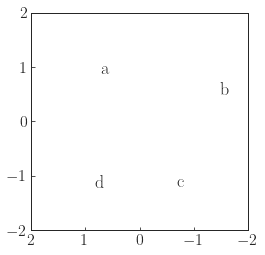

In [11]:
ax = plt.figure().add_subplot(111)

for i, (a, b) in enumerate(zip(model.kwargs_result['kwargs_ps'][0]['ra_image'], model.kwargs_result['kwargs_ps'][0]['dec_image'])):
    ax.plot(a, b)
    ax.text(a, b, ['a', 'b', 'c', 'd'][i])
    ax.set_aspect('equal')
    ax.set_xlim(2, -2)
    ax.set_ylim(-2, 2)

In [12]:
for model in powerlaw_models:
    #model.compute_model_time_delays()
    #model.save_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    model.load_time_delays(model.model_id, '../../../vel_dis/td_', dir_suffix)
    #break

In [13]:
for model in composite_models:
    #model.compute_model_time_delays()
    #model.save_time_delays(model.model_id, '../temp/td_', dir_suffix)
    model.load_time_delays(model.model_id, '../temp/td_', dir_suffix)
    #break

### load Pantheon $D_{\rm s}/D_{\rm  ds}$

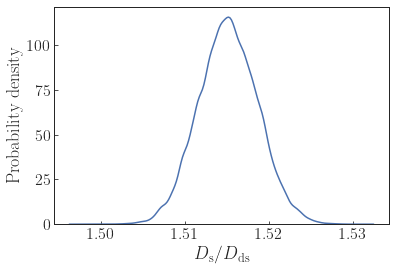

In [14]:
pantheon_Dsds = np.loadtxt('Pantheon_D_sds_distribution.txt')

sns.kdeplot(pantheon_Dsds)
plt.xlabel(r'$D_{\rm s}/D_{\rm ds}$')
plt.ylabel('Probability density');

In [15]:
fiducial_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z_s = 0.777
z_l = 0.230

fiducial_Dsds = fiducial_cosmo.angular_diameter_distance(z_s).value / fiducial_cosmo.angular_diameter_distance_z1z2(z_l, z_s).value

fiducial_Dsds

1.5201658806267908

## Load external convergence

In [16]:
from scipy.interpolate import interp1d


def approx_cdf_1d(x_array, pdf_array):
    """
    Copied from lenstronomy v0.9.2.
    :param x_array: x-values of pdf
    :param pdf_array: pdf array of given x-values
    """
    norm_pdf = pdf_array/np.sum(pdf_array)
    cdf_array = np.zeros_like(norm_pdf)
    cdf_array[0] = norm_pdf[0]
    for i in range(1, len(norm_pdf)):
        cdf_array[i] = cdf_array[i-1] + norm_pdf[i]
    cdf_func = interp1d(x_array, cdf_array)
    cdf_inv_func = interp1d(cdf_array, x_array)
    return cdf_array, cdf_func, cdf_inv_func


class Approx(object):
    """
    Class for approximations with a given pdf sample.
    Copied from lenstronomy v0.9.2.
    """
    def __init__(self, x_array, pdf_array):
        self._cdf_array, self._cdf_func, self._cdf_inv_func = approx_cdf_1d(x_array, pdf_array)

    def draw(self, n=1):
        """

        :return:
        """
        p = np.random.uniform(0, 1, n)
        return self._cdf_inv_func(p)

    @property
    def draw_one(self):
        """

        :return:
        """
        return self.draw(n=1)

### power-law

Number of kappa bins: 2000


/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


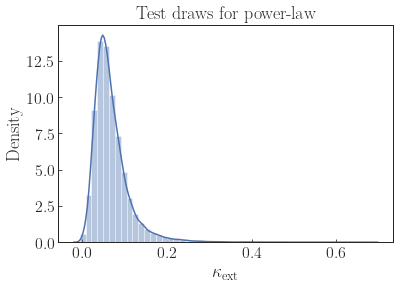

Sampled kappa -> median: 0.058, mean: 0.067, std: 0.043


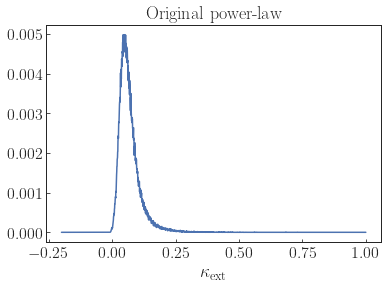

Mean kappa from bins: 0.068


In [17]:
kappa_pl_file = '../data/gammaanowarpowkappahist_2038_measured_3innermask_nobeta_removehandpicked_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_22.5_med_increments2_2_2_emptymsk_shearwithoutprior.cat'

kappa_pl = np.loadtxt(kappa_pl_file)
print('Number of kappa bins:',  len(kappa_pl))

kappa_list = np.linspace(-0.2+0.0003, 1-0.0003, len(kappa_pl))

pdf_list_pl = kappa_pl

pdf_approx_pl = Approx(kappa_list, pdf_list_pl)

pdf_draw_pl = pdf_approx_pl.draw(n=50000)

#plt.hist(pdf_draw, bins=np.linspace(-0.1, 0.2, 100))
sns.distplot(pdf_draw_pl)
plt.title('Test draws for power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

print('Sampled kappa -> median: {:.3f}, mean: {:.3f}, std: {:.3f}'.format(np.median(pdf_draw_pl), np.mean(pdf_draw_pl), np.std(pdf_draw_pl)))

plt.plot(kappa_list, kappa_pl)
plt.title('Original power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

mean_kappa_pl = np.sum(kappa_list*kappa_pl) / np.sum(kappa_pl)
print('Mean kappa from bins: {:.3f}'.format(mean_kappa_pl))

def draw_kappa_pl(n=1):
    return pdf_approx_pl.draw(n=n)

### composite

Number of kappa bins: 2000


/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


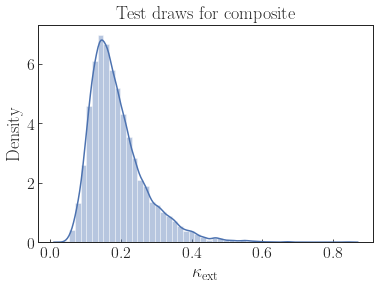

Sampled kappa -> median: 0.173, mean: 0.191, std: 0.080


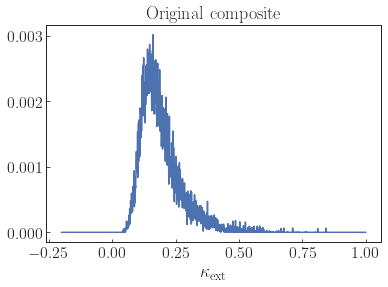

Mean kappa from bins: 0.191


In [18]:
kappa_comp_file = '../data/gammaanowarcompkappahist_2038_measured_3innermask_nobeta_removehandpicked_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_22.5_med_increments2_2_2_emptymsk_shearwithoutprior.cat'
kappa_comp = np.loadtxt(kappa_comp_file)
print('Number of kappa bins:',  len(kappa_comp))

kappa_list = np.linspace(-0.2+0.0003, 1-0.0003, len(kappa_comp))

pdf_list_comp = kappa_comp

pdf_approx_comp = Approx(kappa_list, pdf_list_comp)

pdf_draw_comp = pdf_approx_comp.draw(n=50000)

#plt.hist(pdf_draw, bins=np.linspace(-0.1, 0.2, 100))
sns.distplot(pdf_draw_comp)
plt.title('Test draws for composite')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

print('Sampled kappa -> median: {:.3f}, mean: {:.3f}, std: {:.3f}'.format(np.median(pdf_draw_comp), np.mean(pdf_draw_comp), np.std(pdf_draw_comp)))

plt.plot(kappa_list, kappa_comp)
plt.title('Original composite')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

mean_kappa_comp = np.sum(kappa_list*kappa_comp) / np.sum(kappa_comp)
print('Mean kappa from bins: {:.3f}'.format(mean_kappa_comp))

def draw_kappa_comp(n=1):
    return pdf_approx_comp.draw(n=n)

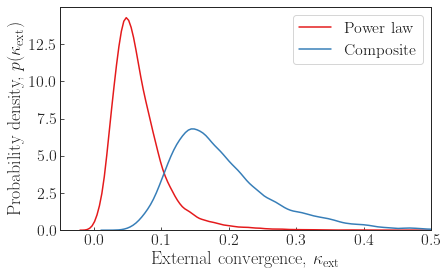

In [19]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))
ax = fig.add_subplot(111)

sns.kdeplot(pdf_draw_pl, ax=ax, label='Power law', color=pf.cb_red)
sns.kdeplot(pdf_draw_comp, ax=ax, label='Composite', color=pf.cb_blue)
ax.set_xlabel(r'External convergence, $\kappa_{\rm ext}$')
ax.set_ylabel(r'Probability density, $p(\kappa_{\rm ext})$')
ax.set_xlim(-0.05, 0.5)
ax.legend()

if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_kappa_ext.pdf', bbox_inches='tight')

## Time-delay predictions assuming $\lambda_{\rm int} = 1$

In [20]:
model.model_velocity_dispersion.shape

powerlaw_kinematics_likelihood = []
composite_kinematics_likelihood = []



def get_kinematics_likelihood(model):
    """
    Get lambda_int distribution from model predicted velocity dispersion.
    """
    log_likelihood = -0.5 * (model.model_velocity_dispersion * np.sqrt(1 - model.kappa_ext) -  model.VEL_DIS[0])**2 / model.SIG_VEL_DIS[0]**2
    
    return np.exp(log_likelihood)

    
for model in powerlaw_models:                                               
    model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
    powerlaw_kinematics_likelihood.append(get_kinematics_likelihood(model))
    
    
for model in composite_models:                                              
    model.kappa_ext = draw_kappa_comp(n=model.model_velocity_dispersion.shape)
    composite_kinematics_likelihood.append(get_kinematics_likelihood(model))

In [21]:
powerlaw_bics = [model.bic for model in powerlaw_models]
composite_bics = [model.bic for model in composite_models]

In [22]:
# From the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69, 304

In [23]:
from getdist import plots
from getdist import MCSamples

Power-law samples importance sampled: (5, 3961)
Removed no burn in
Composite samples importance sampled: (5, 3682)
Removed no burn in
All samples combined and importance sampled: (5, 7644)
Removed no burn in


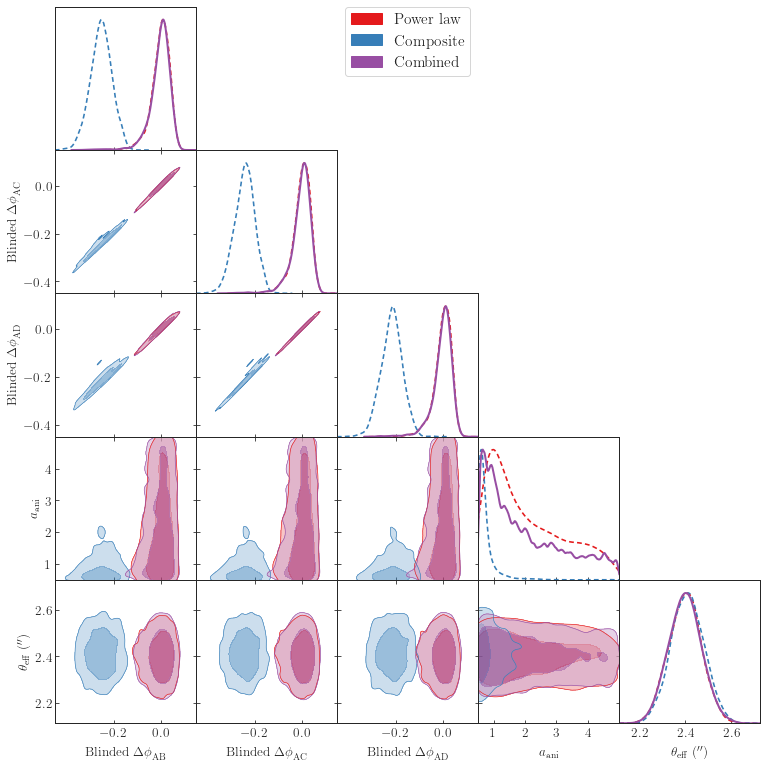

In [24]:
%matplotlib inline

## join powerlaw model samples
pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)

all_pl_samples_wo_kappa_ext = np.array([])
all_pl_samples_lint_1 = np.array([])

pl_kinematic_likelihoods = np.array([])

for k, model in enumerate(powerlaw_models):
    
    num_sample = int(pl_weights[k] * model.get_num_samples())
    
    pl_samples_wo_kappa_ext = np.array([
                           model.model_time_delays[:, 0],
                           model.model_time_delays[:, 1] ,
                           model.model_time_delays[:, 2] ,
                           model.a_ani,
                           model.r_eff
                        ])
    
    pl_samples = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext),
                           model.model_time_delays[:, 1] * (1. - model.kappa_ext),
                           model.model_time_delays[:, 2] * (1. - model.kappa_ext),
                           model.a_ani,
                           model.r_eff
                        ])
    
    pl_kinematic_likelihoods = np.append(pl_kinematic_likelihoods, powerlaw_kinematics_likelihood[k][:num_sample])
    
    if k == 0:
        all_pl_samples_wo_kappa_ext = pl_samples_wo_kappa_ext[:, :num_sample]
        all_pl_samples_lint_1 = pl_samples[:, :num_sample]
    else:
        all_pl_samples_wo_kappa_ext = np.append(all_pl_samples_wo_kappa_ext, pl_samples_wo_kappa_ext[:, :num_sample],
                                                axis=1
                                               )
        all_pl_samples_lint_1 = np.append(all_pl_samples_lint_1, pl_samples[:, :num_sample], axis=1)

importance_sampled_all_pl_indices = np.random.choice(np.arange(all_pl_samples_lint_1.shape[1]),
                                                     size=int(all_pl_samples_lint_1.shape[1]/10),
                                                     p=pl_kinematic_likelihoods/np.sum(pl_kinematic_likelihoods))
importance_sampled_all_pl_samples = all_pl_samples_lint_1[:, importance_sampled_all_pl_indices]


mean_dphi_AB_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[0])
mean_dphi_AC_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[1])
mean_dphi_AD_lambda_int_1 = np.mean(importance_sampled_all_pl_samples[2])


# blinding potential differences
importance_sampled_all_pl_samples[0] = importance_sampled_all_pl_samples[0]/mean_dphi_AB_lambda_int_1 - 1.
importance_sampled_all_pl_samples[1] = importance_sampled_all_pl_samples[1]/mean_dphi_AC_lambda_int_1 - 1.
importance_sampled_all_pl_samples[2] = importance_sampled_all_pl_samples[2]/mean_dphi_AD_lambda_int_1 - 1.


print('Power-law samples importance sampled: {}'.format(importance_sampled_all_pl_samples.shape))


powerlaw_mc_samples= MCSamples(samples=importance_sampled_all_pl_samples.T, 
                               names=[
                                      'dphi_AB', 'dphi_AC', 'dphi_AD', 'a_ani', 'r_eff',
                                     ], 
                              labels=[
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AC}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}',
                                      'a_{\\rm ani}',
                                      '\\theta_{\\rm eff} \ (^{\prime\prime})',
                                     ],
                  )
powerlaw_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
powerlaw_mc_samples.updateSettings({'smooth_scale_1D': 0.3})
    

## join composite model samples
composite_weights = get_relative_weights(composite_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_composite_samples_lint_1 = np.array([])
composite_kinematic_likelihoods = np.array([])

good_sample_number_list = []

for k, model in enumerate(composite_models):
    # rejecting samples that provide zero velocity dispersion
    good_samples = model.model_velocity_dispersion > 1.
    
    good_sample_number_list.append(np.sum(good_samples))
    
    
for k, model in enumerate(composite_models):
    
    # rejecting samples that provide zero velocity dispersion
    good_samples = model.model_velocity_dispersion > 1.
    
    num_sample = int(composite_weights[k] * np.min(good_sample_number_list))
    
    composite_samples = np.array([
                           model.model_time_delays[:, 0] * (1. - model.kappa_ext),
                           model.model_time_delays[:, 1] * (1. - model.kappa_ext),
                           model.model_time_delays[:, 2] * (1. - model.kappa_ext),
                           model.a_ani,
                           model.r_eff,
                        ])
    
    composite_kinematic_likelihoods = np.append(composite_kinematic_likelihoods, 
                                                composite_kinematics_likelihood[k][:num_sample])
    
    composite_samples = composite_samples[:, good_samples]
    
    if k == 0:
        all_composite_samples_lint_1 = composite_samples[:, :num_sample]
    else:
        all_composite_samples_lint_1 = np.append(all_composite_samples_lint_1, composite_samples[:, :num_sample], axis=1)
        
importance_sampled_all_composite_indices = np.random.choice(np.arange(all_composite_samples_lint_1.shape[1]),
                                                     size=int(all_composite_samples_lint_1.shape[1]/10),
                                                     p=composite_kinematic_likelihoods/np.sum(composite_kinematic_likelihoods))
importance_sampled_all_composite_samples = all_composite_samples_lint_1[:, importance_sampled_all_composite_indices]

    
for i in range(all_composite_samples_lint_1.shape[0]):
    all_composite_samples_lint_1[i] = np.nan_to_num(all_composite_samples_lint_1[i], nan=np.nanmean(all_composite_samples_lint_1))


# mean_dphi_AB = np.mean(all_composite_samples[0])
# mean_dphi_AC = np.mean(all_composite_samples[1])
# mean_dphi_AD = np.mean(all_composite_samples[2])

# blinding potential differences
importance_sampled_all_composite_samples[0] = importance_sampled_all_composite_samples[0]/mean_dphi_AB_lambda_int_1 - 1.
importance_sampled_all_composite_samples[1] = importance_sampled_all_composite_samples[1]/mean_dphi_AC_lambda_int_1 - 1.
importance_sampled_all_composite_samples[2] = importance_sampled_all_composite_samples[2]/mean_dphi_AD_lambda_int_1 - 1.

print('Composite samples importance sampled: {}'.format(importance_sampled_all_composite_samples.shape))


composite_mc_samples = MCSamples(samples=importance_sampled_all_composite_samples.T, 
                                 names=[
                                      'dphi_AB', 'dphi_AC', 'dphi_AD', 'a_ani', 'r_eff', 
                                     ], 
                              labels=[
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', 
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AC}', 
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', 
                                      'a_{\\rm ani}',
                                      '\\theta_{\\rm eff} \ (\\prime\\prime)}',
                                     ],
                  )

composite_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
composite_mc_samples.updateSettings({'smooth_scale_1D': 0.3})
    
    
all_samples = np.append(all_pl_samples_lint_1, all_composite_samples_lint_1, axis=1)
all_kinematic_likelihoods = np.append(pl_kinematic_likelihoods, composite_kinematic_likelihoods)

importance_sampled_all_indices = np.random.choice(np.arange(all_samples.shape[1]),
                                                     size=int(all_samples.shape[1]/10),
                                                     p=all_kinematic_likelihoods/np.sum(all_kinematic_likelihoods))
importance_sampled_all_samples = all_samples[:, importance_sampled_all_indices]


importance_sampled_all_samples[0] = importance_sampled_all_samples[0]/mean_dphi_AB_lambda_int_1 - 1.
importance_sampled_all_samples[1] = importance_sampled_all_samples[1]/mean_dphi_AC_lambda_int_1 - 1.
importance_sampled_all_samples[2] = importance_sampled_all_samples[2]/mean_dphi_AD_lambda_int_1 - 1.

print('All samples combined and importance sampled: {}'.format(importance_sampled_all_samples.shape))


all_mc_samples = MCSamples(samples=importance_sampled_all_samples.T, 
                                 names=[
                                      'dphi_AB', 'dphi_AC', 'dphi_AD', 'a_ani', 'r_eff', 
                                     ], 
                              labels=[
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}', 
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AC}', 
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}', 
                                      'a_{\\rm ani}',
                                      '\\theta_{\\rm eff} \\ (\prime\prime)}',
                                     ],
                  )


pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 16

g.settings.legend_fontsize = 18
# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([powerlaw_mc_samples, composite_mc_samples, all_mc_samples],
                 legend_labels=['Power law', 'Composite', 'Combined'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6, 2.], 
                 contour_ls=['--', '--', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors+[pf.cb_purple],
                 param_limits={'dphi_AB': (-0.45, 0.15), 
                               'dphi_AC': (-0.45, 0.15), 
                               'dphi_AD': (-0.45, 0.15), 
                               'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                 #fontsize=100
               )

#g.fig.tight_layout()
if save_fig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_mst_uncorrected_fermat_potential.pdf', bbox_inches='tight')

In [25]:
print('Power law:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(importance_sampled_all_pl_samples[i, :])))
    
print('Composite:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(importance_sampled_all_composite_samples[i, :])))
    
print('Combined:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(importance_sampled_all_samples[i, :])))

Power law:
	 Delta_phi_AB: 0.04
	 Delta_phi_AC: 0.04
	 Delta_phi_AD: 0.04
Composite:
	 Delta_phi_AB: 0.05
	 Delta_phi_AC: 0.04
	 Delta_phi_AD: 0.05
Combined:
	 Delta_phi_AB: 0.04
	 Delta_phi_AC: 0.04
	 Delta_phi_AD: 0.04



## Time-delay predictions with free $\lambda_{\rm int}$

In [26]:
model.model_velocity_dispersion.shape

(10000,)

In [27]:
powerlaw_lambda_ints = []
composite_lambda_ints = []


def get_lambda_ints(model):
    """
    Get lambda_int distribution from model predicted velocity dispersion.
    """
    observed_velocity_dispersion = np.random.normal(loc=model.VEL_DIS[0], scale=model.SIG_VEL_DIS[0], 
                                                    size=model.get_num_samples()
                                                   )
    
    # c^2 x J function
    Jc2 = model.model_velocity_dispersion**2 / fiducial_Dsds 
    lambda_ints = observed_velocity_dispersion**2 / (Jc2 * np.random.choice(
                                                        pantheon_Dsds, 
                                                        size=model.get_num_samples())) / (1 - model.kappa_ext)
    
    return lambda_ints

    
for model in powerlaw_models:                                               
    model.kappa_ext = draw_kappa_pl(n=model.model_velocity_dispersion.shape)
    powerlaw_lambda_ints.append(get_lambda_ints(model))
    
    
for model in composite_models:                                              
    model.kappa_ext = draw_kappa_comp(n=model.model_velocity_dispersion.shape)
    composite_lambda_ints.append(get_lambda_ints(model))


## Plot

In [28]:
from getdist import plots
from getdist import MCSamples

In [29]:
powerlaw_bics = [model.bic for model in powerlaw_models]
composite_bics = [model.bic for model in composite_models]

In [30]:
# From the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69, 304

Power-law samples: (6, 39692)
Removed no burn in
Composite samples: (6, 36803)
Removed no burn in


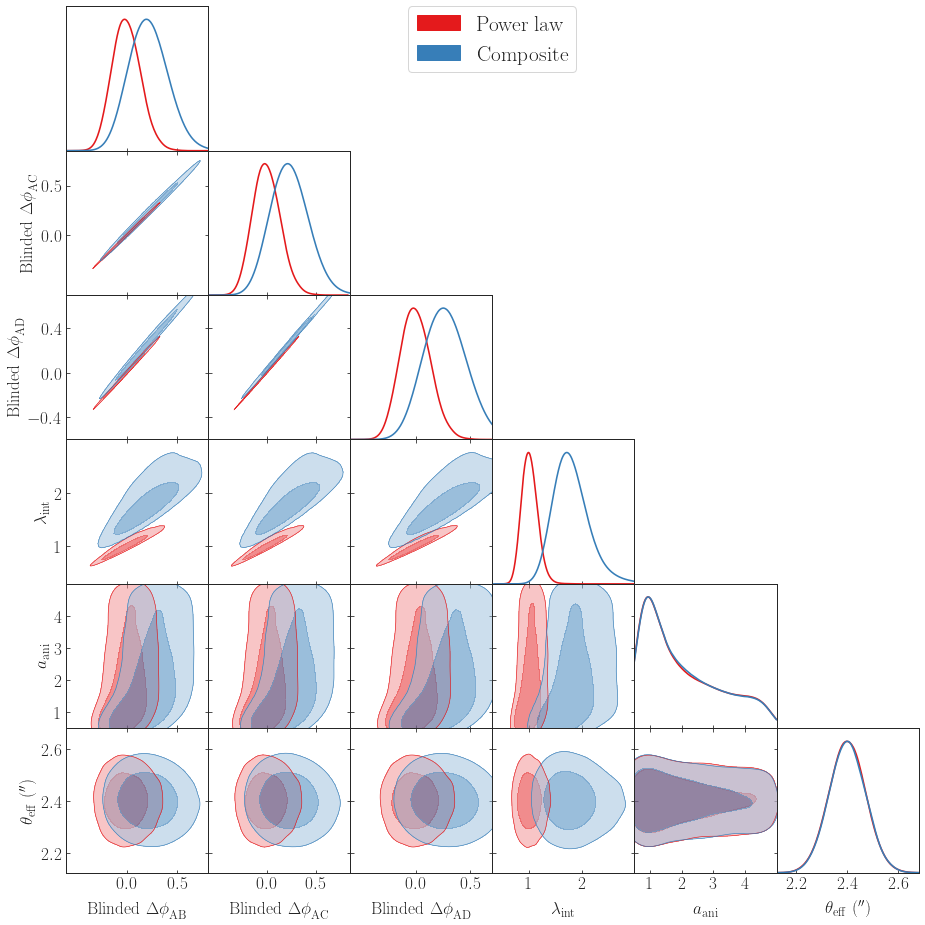

In [31]:
%matplotlib inline

## join powerlaw model samples
pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_pl_samples = np.array([])

for k, model in enumerate(powerlaw_models):
    
    num_sample = int(pl_weights[k] * model.get_num_samples())
    
    lambda_ints = powerlaw_lambda_ints[k]
    
    pl_samples = np.array([model.model_time_delays[:, 0] * (1. - model.kappa_ext) * lambda_ints,
                           model.model_time_delays[:, 1] * (1. - model.kappa_ext) * lambda_ints,
                           model.model_time_delays[:, 2] * (1. - model.kappa_ext) * lambda_ints,
                           lambda_ints,
                           model.a_ani,
                           model.r_eff
                        ])
    if k == 0:
        all_pl_samples = pl_samples[:, :num_sample]
    else:
        all_pl_samples = np.append(all_pl_samples, pl_samples[:, :num_sample], axis=1)
    

mean_dphi_AB = np.mean(all_pl_samples[0])
mean_dphi_AC = np.mean(all_pl_samples[1])
mean_dphi_AD = np.mean(all_pl_samples[2])

# blinding potential differences
all_pl_samples[0] = all_pl_samples[0]/mean_dphi_AB - 1.
all_pl_samples[1] = all_pl_samples[1]/mean_dphi_AC - 1.
all_pl_samples[2] = all_pl_samples[2]/mean_dphi_AD - 1.


print('Power-law samples: {}'.format(all_pl_samples.shape))


powerlaw_mc_samples= MCSamples(samples=all_pl_samples.T, 
                               names=[
                                      'dphi_AB', 'dphi_AC', 'dphi_AD', 'lambda_int', 'a_ani', 'r_eff',
                                     ], 
                              labels=[
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AC}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}',
                                      '\\lambda_{\\rm int}',
                                      'a_{\\rm ani}',
                                      '\\theta_{\\rm eff}\ (^{\prime\prime})',
                                     ],
                  )
powerlaw_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
powerlaw_mc_samples.updateSettings({'smooth_scale_1D': 0.3})
    

## join composite model samples
composite_weights = get_relative_weights(composite_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_composite_samples = np.array([])

for k, model in enumerate(composite_models):
    
    # rejecting samples that provide zero velocity dispersion
    good_samples = model.model_velocity_dispersion > 1.
    
    num_sample = int(composite_weights[k] * np.sum(good_samples))
    
    lambda_ints = composite_lambda_ints[k]
    kappa_ext = 0.
    
    composite_samples = np.array([
                           model.model_time_delays[:, 0] * (1. - model.kappa_ext) * lambda_ints,
                           model.model_time_delays[:, 1] * (1. - model.kappa_ext) * lambda_ints,
                           model.model_time_delays[:, 2] * (1. - model.kappa_ext) * lambda_ints,
                           lambda_ints,
                           model.a_ani,
                           model.r_eff,
                        ])
    composite_samples = composite_samples[:, good_samples]
    
    if k == 0:
        all_composite_samples = composite_samples[:, :num_sample]
    else:
        all_composite_samples = np.append(all_composite_samples, composite_samples[:, :num_sample], axis=1)
    
for i in range(all_composite_samples.shape[0]):
    all_composite_samples[i] = np.nan_to_num(all_composite_samples[i], nan=np.nanmean(all_composite_samples))


# mean_dphi_AB = np.mean(all_composite_samples[0])
# mean_dphi_AC = np.mean(all_composite_samples[1])
# mean_dphi_AD = np.mean(all_composite_samples[2])

# blinding potential differences
all_composite_samples[0] = all_composite_samples[0]/mean_dphi_AB - 1.
all_composite_samples[1] = all_composite_samples[1]/mean_dphi_AC - 1.
all_composite_samples[2] = all_composite_samples[2]/mean_dphi_AD - 1.

print('Composite samples: {}'.format(all_composite_samples.shape))


composite_mc_samples = MCSamples(samples=all_composite_samples.T, 
                                 names=[
                                      'dphi_AB', 'dphi_AC', 'dphi_AD', 'lambda_int', 'a_ani', 'r_eff', 
                                     ], 
                              labels=[
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AB}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AC}',
                                      '{\\rm Blinded} \\ \\Delta \\phi^{\\rm}_{\\rm AD}',
                                      '\\lambda_{\\rm int}',
                                      'a_{\\rm ani}',
                                      '\\theta_{\\rm eff} \\ {\\rm (arcsec)}',
                                     ],
                  )

composite_mc_samples.updateSettings({'smooth_scale_2D': 0.3})
composite_mc_samples.updateSettings({'smooth_scale_1D': 0.3})
    

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 20

g.settings.legend_fontsize = 24
# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([powerlaw_mc_samples, composite_mc_samples],
                 legend_labels=['Power law', 'Composite'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6], 
                 contour_ls=['-', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors,
                 param_limits={'dphi_AB': (-0.6, 0.8), 'dphi_AC': (-0.6, 0.85), 'dphi_AD': (-0.6, 0.7), 
                               'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                 #fontsize=100
               )

#g.fig.tight_layout()
if save_fig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_mst_corrected_fermat_potential.pdf', bbox_inches='tight')

### spit out $\lambda_{\rm int}$ distribution

In [32]:
print('Power-law lambda_int: {:.2f} ± {:.2f}'.format(np.median(all_pl_samples[3, :]), 
                                                               np.std(all_pl_samples[3, :])))
                                                               
                                                               
print('Composite lambda_int: {:.2f} ± {:.2f}'.format(np.median(all_composite_samples[3, :]), 
                                                               np.std(all_composite_samples[3, :])))
                                                                                                          

Power-law lambda_int: 1.00 ± 0.16
Composite lambda_int: 1.77 ± 0.52


## Fermat potential/time-delay uncertainty levels

In [33]:
print('Power law:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(all_pl_samples[i, :])))
    
print('Composite:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(all_composite_samples[i, :])))
    
number_of_samples = min(all_pl_samples.shape[1], all_composite_samples.shape[1])
combined_time_delays = np.append(all_pl_samples[:3, :number_of_samples], all_composite_samples[:3, :number_of_samples], axis=1)

print('Combined:')
for i, pair in enumerate(['AB', 'AC', 'AD']):
    print('\t Delta_phi_{}: {:.2f}'.format(pair, np.std(combined_time_delays[i, :])))


Power law:
	 Delta_phi_AB: 0.14
	 Delta_phi_AC: 0.14
	 Delta_phi_AD: 0.14
Composite:
	 Delta_phi_AB: 0.29
	 Delta_phi_AC: 0.34
	 Delta_phi_AD: 0.33
Combined:
	 Delta_phi_AB: 0.26
	 Delta_phi_AC: 0.29
	 Delta_phi_AD: 0.29


## Final time-delay prediction

## comparison with Glee

In [34]:
mean_AB = mean_dphi_AB_lambda_int_1
mean_AC = mean_dphi_AC_lambda_int_1
mean_AD = mean_dphi_AD_lambda_int_1

blind = False

def unblind(arr, i):
    m = [mean_AB, mean_AC, mean_AD][i]
    if blind:
        return arr
    else:
        return ((arr + 1.) * m)
    
def unblind_glee(arr, weight):
    if blind:
        mean = np.sum(arr*weight)/np.sum(weight)
        return arr/mean - 1.
    else:
        return -arr
    
# from https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

### all combined

In [35]:
glee_all = np.genfromtxt('../model_posteriors/glee_desj2038_td_weight_all.dat', skip_header=1, delimiter=',')

glee_all.shape

(1200000, 8)

In [36]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
#mpl.rc("text", usetex=false) # allow tex rendering
mpl.rcParams["font.family"] = "Times New Roman"#mplrc("axes", labelsize="18")


In [37]:
size = 100000
smoothing = None

def plot_glee_posterior(arr, weights, ax):
    indices = np.random.choice(np.arange(arr.shape[0]), size=size, p=weights/np.sum(weights))
    
    #sns.kdeplot(td[:, 1] - comp_means[0], weights=td[:, 0], alpha=alpha, label=l,
    sns.kdeplot(arr[indices], color=pf.cb_purple, 
                label=r'$\textsc{Glee}$', bw_method=smoothing,
                ax=ax,
               )

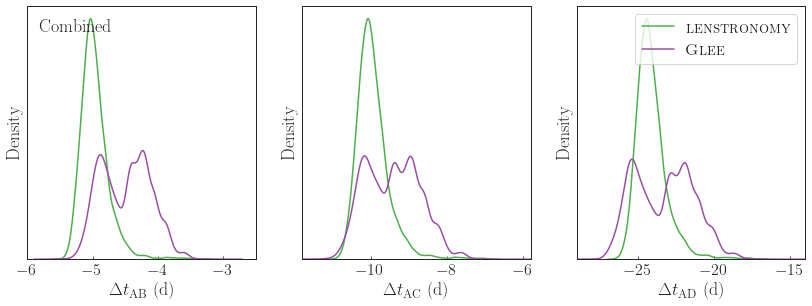

In [38]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=1/3.))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

smoothing = 0.15

sns.kdeplot(unblind(importance_sampled_all_samples[:3][0], 0), ax=ax1, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_method=smoothing)
sns.kdeplot(unblind(importance_sampled_all_samples[:3][1], 1), ax=ax2, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_method=smoothing)
sns.kdeplot(unblind(importance_sampled_all_samples[:3][2], 2), ax=ax3, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_method=smoothing)

# sns.kdeplot(unblind_glee(glee_all[:, 2], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax1, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_all[:, 3], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax2, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_all[:, 4], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax3, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)

plot_glee_posterior(unblind_glee(glee_all[:, 2], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax1) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_all[:, 3], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax2) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_all[:, 4], glee_all[:, 1]), weights=glee_all[:, 1], ax=ax3) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)


ax1.set_xlabel(r'$\Delta t_{\rm AB}$ (d)')
ax2.set_xlabel(r'$\Delta t_{\rm AC}$ (d)')
ax3.set_xlabel(r'$\Delta t_{\rm AD}$ (d)')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

if blind:
    w = 0.4
    limit = [[-w, w]]*3 
else:
    p = 0.3
    limit = [[mean_AB * (1-p), mean_AB * (1+p)], 
             [mean_AC * (1-p), mean_AC * (1+p)], 
             [mean_AD * (1-p), mean_AD * (1+p)]]

ax1.set_xlim(-6., -2.5) #limit[0][0], limit[0][1])
ax2.set_xlim(-11.8, -5.8) #limit[1][0], limit[1][1])
ax3.set_xlim(-29, -14) #limit[2][0], limit[2][1]);

ax1.text(0.05, 0.9, 'Combined', transform=ax1.transAxes)
            
ax3.legend(loc='upper right')

if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/time_delay_compare_combined.pdf', bbox_inches='tight')

In [39]:
for i in range(3):
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind(importance_sampled_all_samples[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(glee_all[:, 2+i], glee_all[:, 1]), sample_weight=glee_all[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) * 2.
            )
         )
    

Difference: 10.99 %, 1.23 sigma
Difference: 6.04 %, 0.71 sigma
Difference: 5.00 %, 0.53 sigma


### power-law only

In [40]:
glee_pl = np.genfromtxt('../model_posteriors/glee_desj2038_td_weight_pl.dat', skip_header=1, delimiter=',')

glee_pl.shape

(600000, 8)

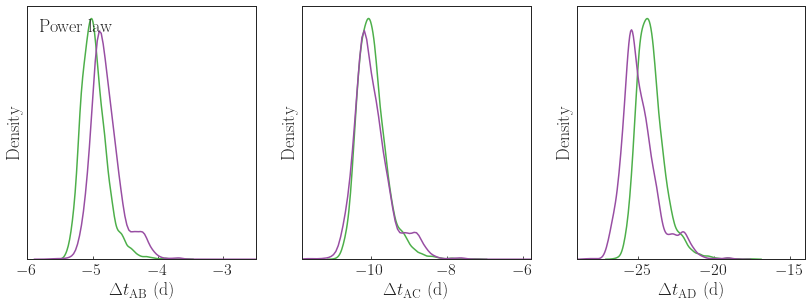

In [41]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=1/3.))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

smoothing = 0.15

sns.kdeplot(unblind(importance_sampled_all_pl_samples[:3][0], 0), ax=ax1, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_adjust=smoothing)
sns.kdeplot(unblind(importance_sampled_all_pl_samples[:3][1], 1), ax=ax2, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_adjust=smoothing)
sns.kdeplot(unblind(importance_sampled_all_pl_samples[:3][2], 2), ax=ax3, color=pf.cb_green, label=r'$\textsc{lenstronomy}$') #, bw_adjust=smoothing)

# sns.kdeplot(unblind_glee(glee_pl[:, 2], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax1, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_pl[:, 3], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax2, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_pl[:, 4], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax3, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)

plot_glee_posterior(unblind_glee(glee_pl[:, 2], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax1) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_pl[:, 3], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax2) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_pl[:, 4], glee_pl[:, 1]), weights=glee_pl[:, 1], ax=ax3) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)


ax1.set_xlabel(r'$\Delta t_{\rm AB}$ (d)')
ax2.set_xlabel(r'$\Delta t_{\rm AC}$ (d)')
ax3.set_xlabel(r'$\Delta t_{\rm AD}$ (d)')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

if blind:
    w = 0.4
    limit = [[-w, w]]*3 
else:
    p = 0.3
    limit = [[mean_AB * (1-p), mean_AB * (1+p)], 
             [mean_AC * (1-p), mean_AC * (1+p)], 
             [mean_AD * (1-p), mean_AD * (1+p)]]

ax1.set_xlim(-6., -2.5) #limit[0][0], limit[0][1])
ax2.set_xlim(-11.8, -5.8) #limit[1][0], limit[1][1])
ax3.set_xlim(-29, -14) #limit[2][0], limit[2][1]);

ax1.text(0.05, 0.9, 'Power law', transform=ax1.transAxes)
            
#ax3.legend(loc='upper right')
if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/time_delay_compare_powerlaw.pdf', bbox_inches='tight')

In [42]:
for i in range(3):
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind(importance_sampled_all_pl_samples[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(glee_pl[:, 2+i], glee_pl[:, 1]), sample_weight=glee_pl[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) * 2.
            )
         )
    

Difference: 3.31 %, 0.61 sigma
Difference: 0.35 %, 0.07 sigma
Difference: 3.21 %, 0.62 sigma


### composite only

In [43]:
glee_comp = np.genfromtxt('../model_posteriors/glee_desj2038_td_weight_comp.dat', skip_header=1, delimiter=',')

glee_comp.shape

(600000, 8)

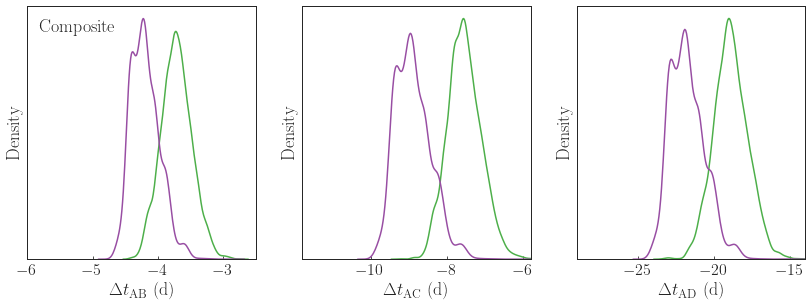

In [44]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=1/3.))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.kdeplot(unblind(importance_sampled_all_composite_samples[:3][0], 0), ax=ax1, color=pf.cb_green, label=r'$\textsc{lenstronomy}$')
sns.kdeplot(unblind(importance_sampled_all_composite_samples[:3][1], 1), ax=ax2, color=pf.cb_green, label=r'$\textsc{lenstronomy}$')
sns.kdeplot(unblind(importance_sampled_all_composite_samples[:3][2], 2), ax=ax3, color=pf.cb_green, label=r'$\textsc{lenstronomy}$')

smoothing = 0.25
# sns.kdeplot(unblind_glee(glee_comp[:, 2], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax1, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_comp[:, 3], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax2, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
# sns.kdeplot(unblind_glee(glee_comp[:, 4], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax3, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_comp[:, 2], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax1) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_comp[:, 3], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax2) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
plot_glee_posterior(unblind_glee(glee_comp[:, 4], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax3) #, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)


ax1.set_xlabel(r'$\Delta t_{\rm AB}$ (d)')
ax2.set_xlabel(r'$\Delta t_{\rm AC}$ (d)')
ax3.set_xlabel(r'$\Delta t_{\rm AD}$ (d)')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

if blind:
    w = 0.4
    limit = [[-w, w]]*3 
else:
    p = 0.3
    limit = [[mean_AB * 0.8 * (1-p), mean_AB * 0.8 * (1+p)], 
             [mean_AC * 0.8 * (1-p), mean_AC * 0.8 * (1+p)], 
             [mean_AD * 0.8 * (1-p), mean_AD * 0.8 * (1+p)]]

ax1.set_xlim(-6., -2.5) #limit[0][0], limit[0][1])
ax2.set_xlim(-11.8, -5.8) #limit[1][0], limit[1][1])
ax3.set_xlim(-29, -14) #limit[2][0], limit[2][1]);

ax1.text(0.05, 0.9, 'Composite', transform=ax1.transAxes)
            
#ax3.legend(loc='upper right')
if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/time_delay_compare_composite.pdf', bbox_inches='tight')

In [45]:
for i in range(3):
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind(importance_sampled_all_composite_samples[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(glee_comp[:, 2+i], glee_comp[:, 1]), sample_weight=glee_comp[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) *  2.
            )
         )
    

Difference: 11.65 %, 1.56 sigma
Difference: 15.40 %, 2.18 sigma
Difference: 13.40 %, 1.86 sigma


### $H_0$ dependency plot

In [46]:
#combined_time_delays = np.append(all_pl_samples[:3], all_composite_samples[:3], axis=1)
combined_time_delays = importance_sampled_all_samples[:3]

# for i, m in enumerate([mean_dphi_AB_lambda_int_1, mean_dphi_AC_lambda_int_1, mean_dphi_AD_lambda_int_1]):
#     combined_time_delays[i] += 1
#     combined_time_delays[i] *= m
#     combined_time_delays[i] = combined_time_delays[i]/np.median(combined_time_delays[i]) - 1.

time_delay_high, time_delay_med, time_delay_low = [], [], [] 

for i in range(3):
    
    lo, med, hi = np.percentile(unblind(combined_time_delays[i], i), q=[16, 50, 84])
    
    time_delay_high.append(hi)
    time_delay_low.append(lo)
    time_delay_med.append(med)
    

In [47]:
import pandas as pd

glee_time_delays = pd.read_csv('../../glee_outputs/glee_td.csv')

glee_time_delays

,h0,td_ab_med,td_ab_lo,td_ab_hi,td_ac_med,td_ac_lo,td_ac_hi,td_ad_med,td_ad_lo,td_ad_hi
0,60.0,1.166667,1.073749,1.288734,1.166667,1.074667,1.266561,1.166667,1.073801,1.288673
1,61.0,1.147541,1.056147,1.267607,1.147541,1.057050,1.245797,1.147541,1.056198,1.267548
2,62.0,1.129032,1.039112,1.247162,1.129032,1.040000,1.225704,1.129032,1.039163,1.247103
3,63.0,1.111111,1.022618,1.227365,1.111111,1.023492,1.206248,1.111111,1.022668,1.227308
4,64.0,1.093750,1.006640,1.208188,1.093750,1.007500,1.187401,1.093750,1.006689,1.208131
5,65.0,1.076923,0.991153,1.189600,1.076923,0.992000,1.169133,1.076923,0.991201,1.189545
6,66.0,1.060606,0.976136,1.171576,1.060606,0.976970,1.151419,1.060606,0.976183,1.171521
7,67.0,1.044776,0.961567,1.154090,1.044776,0.962388,1.134234,1.044776,0.961613,1.154036
8,68.0,1.029412,0.947426,1.137118,1.029412,0.948236,1.117554,1.029412,0.947472,1.137065
9,69.0,1.014493,0.933695,1.120638,1.014493,0.934493,1.101357,1.014493,0.933740,1.120586


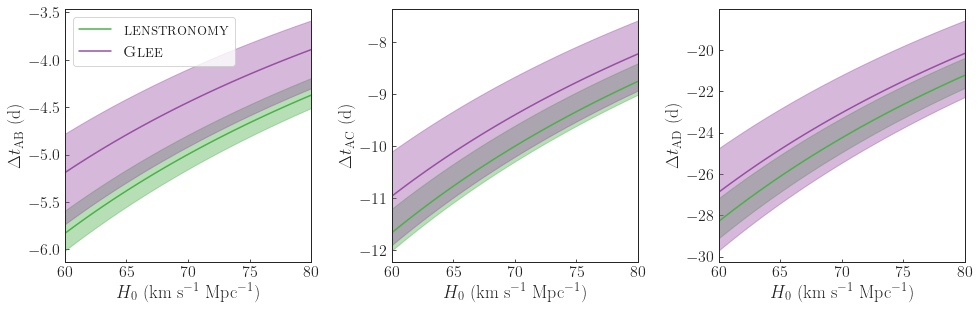

In [48]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
#mpl.rc("text", usetex=false) # allow tex rendering
mpl.rcParams["font.family"] = "Times New Roman"#mplrc("axes", labelsize="18")

fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=1/3.))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

axes = [ax1, ax2, ax3]
pair_names = [r'$\Delta t_{\rm AB}$ (d)', r'$\Delta t_{\rm AC}$ (d)', r'$\Delta t_{\rm AD}$ (d)']

H0s = np.linspace(60, 80, 100)

column_names = glee_time_delays.columns

for i, ax in enumerate(axes):

        
    #ax.plot(glee_time_delays['h0'], glee_time_delays[column_names[3*i+1]] - 1, color=pf.cb_purple, label=r'$\textsc{Glee}$')
    #ax.fill_between(glee_time_delays['h0'], glee_time_delays[column_names[3*i+2]] - 1, glee_time_delays[column_names[3*i+3]] - 1, color=pf.cb_purple, alpha=0.4)

    
    ax.fill_between(H0s, (time_delay_high[i])/H0s*70., (time_delay_low[i])/H0s*70., color=pf.cb_green, alpha=0.4)
    ax.plot(H0s, (time_delay_med[i])/H0s*70., color=pf.cb_green, label=r'$\textsc{lenstronomy}$')
    
    glee_hi, glee_med, glee_low = weighted_quantile(unblind_glee(glee_all[:, 2+i], glee_all[:, 1]), 
                                                    sample_weight=glee_all[:, 1], quantiles=[0.84, 0.5, 0.16],
                                                    old_style=True
                                                   )
    
    ax.fill_between(H0s, (glee_hi)/H0s*70., (glee_low)/H0s*70., color=pf.cb_purple, alpha=0.4)
    ax.plot(H0s, (glee_med)/H0s*70., color=pf.cb_purple, label=r'$\textsc{Glee}$')
            
    ax.set_xlim(H0s[0], H0s[-1])
    #ax.set_ylim(-0.4, 0.4)
    ax.set_xlabel(r'$H_0$ (km s$^{-1}$ Mpc$^{-1}$)')
    ax.set_ylabel(pair_names[i])
    if i == 0:
        ax.legend()

fig.tight_layout()
        
if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/time_delay_prediction.pdf', bbox_inches='tight')

In [49]:
# print time-delay predictions
labels = ['AB', 'AC', 'AD']

print("lenstronomy")
for i in range(3):
    h, m, l = time_delay_high[i], time_delay_med[i], time_delay_low[i]
    print(r'$\Delta t_{{ \rm {} }} = {:.1f}^{{ +{:.1f} }}_{{ -{:.1f} }}$ days'.format(labels[i], m, h-m, m-l))
    
    
print("Glee")
for i in range(3):
    glee_hi, glee_med, glee_low = weighted_quantile(unblind_glee(glee_all[:, 2+i], glee_all[:, 1]), 
                                                    sample_weight=glee_all[:, 1], quantiles=[0.84, 0.5, 0.16],
                                                    old_style=True
                                                   )
    print(r'$\Delta t_{{ \rm {} }} = {:.1f}^{{ +{:.1f} }}_{{ -{:.1f} }}$ days'.format(labels[i], glee_med, 
                                                                                      glee_hi - glee_med,
                                                                                      glee_med - glee_low))
#     print('Glee: ', labels[i], glee_med, '+', glee_hi - glee_med, '-', glee_med - glee_lo)

lenstronomy
$\Delta t_{ \rm AB } = -5.0^{ +0.2 }_{ -0.2 }$ days
$\Delta t_{ \rm AC } = -10.0^{ +0.4 }_{ -0.3 }$ days
$\Delta t_{ \rm AD } = -24.3^{ +1.0 }_{ -0.7 }$ days
Glee
$\Delta t_{ \rm AB } = -4.4^{ +0.4 }_{ -0.5 }$ days
$\Delta t_{ \rm AC } = -9.4^{ +0.7 }_{ -0.8 }$ days
$\Delta t_{ \rm AD } = -23.0^{ +1.8 }_{ -2.4 }$ days


### Fermat potential comparison

In [50]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

time_delay2fermat_pot = lens_cosmo.time_delay2fermat_pot(1.)

time_delay2fermat_pot

0.024359500429646182

In [51]:
blind = False

def unblind_pot(arr, i):
    m = [mean_dphi_AB,
         mean_dphi_AC,
         mean_dphi_AD][i]
    
    if blind:
        return arr/np.mean(arr) - 1.
    else:
        return arr * time_delay2fermat_pot

In [59]:
glee_potentials_pl = np.genfromtxt('../model_posteriors/glee_desj2038_modelparams_weight_pl.dat', 
                                   skip_header=1, delimiter=',')

glee_potentials_comp = np.genfromtxt('../model_posteriors/glee_desj2038_modelparams_weight_comp.dat', 
                                   skip_header=1, delimiter=',')

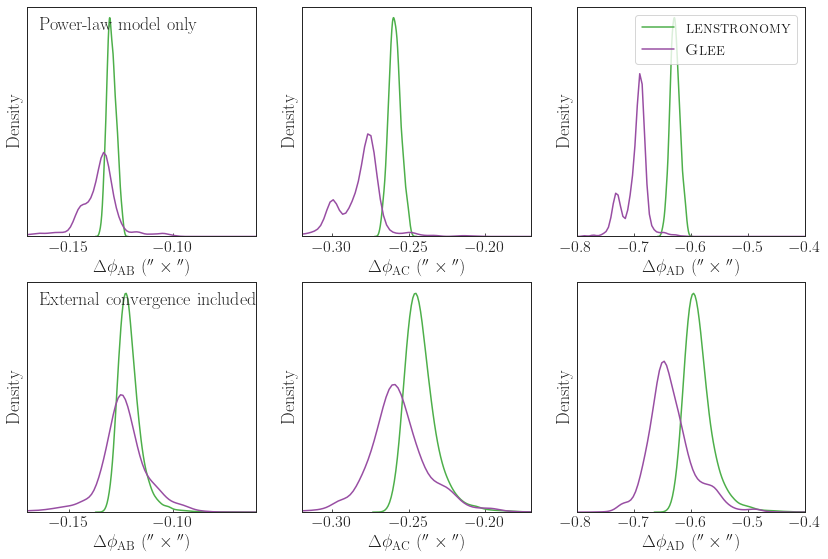

In [53]:
# power-law
#index,final_wht,theta_E,gamma,q_mass,PA_mass,gamma_ext,phi_ext,vd_pred,kappa_ext,phi_ab,phi_ac,phi_ad,phi_bc,phi_bd,phi_cd

fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=2/3.))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

sns.kdeplot(unblind_pot(all_pl_samples_wo_kappa_ext[:3][0], 0), ax=ax1, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)
sns.kdeplot(unblind_pot(all_pl_samples_wo_kappa_ext[:3][1], 1), ax=ax2, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)
sns.kdeplot(unblind_pot(all_pl_samples_wo_kappa_ext[:3][2], 2), ax=ax3, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)

smoothing = 0.2
sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 10], glee_potentials_pl[:, 1]), ax=ax1, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 11], glee_potentials_pl[:, 1]), ax=ax2, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 12], glee_potentials_pl[:, 1]), ax=ax3, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)

ax1.set_xlabel(r'$\Delta \phi_{\rm AB}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')
ax2.set_xlabel(r'$\Delta \phi_{\rm AC}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')
ax3.set_xlabel(r'$\Delta \phi_{\rm AD}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

ax3.legend(loc='upper right')
ax1.text(0.05, 0.9, 'Power-law model only', transform=ax1.transAxes)

limit = [
    [-0.17, -0.06],
    [-0.32, -0.17],
    [-0.8, -0.4]
]

ax1.set_xlim(limit[0][0], limit[0][1])
ax2.set_xlim(limit[1][0], limit[1][1])
ax3.set_xlim(limit[2][0], limit[2][1]);


ax1 = fig.add_subplot(234)
ax2 = fig.add_subplot(235)
ax3 = fig.add_subplot(236)

sns.kdeplot(unblind_pot(all_pl_samples_lint_1[:3][0], 0), ax=ax1, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)
sns.kdeplot(unblind_pot(all_pl_samples_lint_1[:3][1], 1), ax=ax2, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)
sns.kdeplot(unblind_pot(all_pl_samples_lint_1[:3][2], 2), ax=ax3, color=pf.cb_green, label=r'$\textsc{lenstronomy}$', bw_method=smoothing)

sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 10], glee_potentials_pl[:, 1]) * (1 - glee_potentials_pl[:, 9]), ax=ax1, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 11], glee_potentials_pl[:, 1]) * (1 - glee_potentials_pl[:, 9]), ax=ax2, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)
sns.kdeplot(unblind_glee(-glee_potentials_pl[:, 12], glee_potentials_pl[:, 1]) * (1 - glee_potentials_pl[:, 9]), ax=ax3, color=pf.cb_purple, label=r'$\textsc{Glee}$', bw_method=smoothing)

ax1.set_xlabel(r'$\Delta \phi_{\rm AB}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')
ax2.set_xlabel(r'$\Delta \phi_{\rm AC}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')
ax3.set_xlabel(r'$\Delta \phi_{\rm AD}$ (${}^{\prime\prime} \times {}^{\prime\prime}$)')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

ax1.text(0.05, 0.9, 'External convergence included', transform=ax1.transAxes)

# if blind:
#     w = 0.4
#     limit = [[-w, w]]*3 
# else:
#     p = 0.3
#     limit = [[mean_AB * (1-p)*time_delay2fermat_pot, mean_AB * (1+p)*time_delay2fermat_pot], 
#              [mean_AC * (1-p)*time_delay2fermat_pot, mean_AC * (1+p)*time_delay2fermat_pot], 
#              [mean_AD * (1-p)*time_delay2fermat_pot, mean_AD * (1+p)*time_delay2fermat_pot]]


ax1.set_xlim(limit[0][0], limit[0][1])
ax2.set_xlim(limit[1][0], limit[1][1])
ax3.set_xlim(limit[2][0], limit[2][1]);


if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/pl_potential_difference_kappa_ext.pdf', bbox_inches='tight')

In [54]:
print('w/o external convergence')
for i in range(3):
    glee_ind = [10, 11, 12]
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind_pot(all_pl_samples_wo_kappa_ext[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(-glee_potentials_pl[:, glee_ind[i]], glee_potentials_pl[:, 1]) , 
                                                   sample_weight=glee_comp[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) *  2.
            )
         )
    
    
print('w/ external convergence')
for i in range(3):
    glee_ind = [10, 11, 12]
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind_pot(all_pl_samples_lint_1[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(-glee_potentials_pl[:, glee_ind[i]], glee_potentials_pl[:, 1]) * (1 - glee_potentials_pl[:, 9]), 
                                                   sample_weight=glee_comp[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) *  2.
            )
         )
    
    
print('with kinematic weighting')
for i in range(3):
    lenstronomy_lo, lenstronomy_med, lenstronomy_hi = np.percentile(unblind(importance_sampled_all_pl_samples[:3][i], i), q=[16, 50, 84])
    glee_lo, glee_med, glee_hi = weighted_quantile(unblind_glee(glee_pl[:, 2+i], glee_pl[:, 1]), sample_weight=glee_pl[:, 1], quantiles=[0.16, 0.5, 0.84], 
                                 old_style=True)
    
    print('Difference: {:.2f} %, {:.2f} sigma'.format(
                np.abs(lenstronomy_med - glee_med) / np.max([np.abs(lenstronomy_med), np.abs(glee_med)]) * 100,
                np.abs(lenstronomy_med - glee_med) / np.sqrt((lenstronomy_hi - lenstronomy_lo)**2 + (glee_hi - glee_lo)**2) * 2.
            )
         )
    

w/o external convergence
Difference: 3.23 %, 1.14 sigma
Difference: 6.73 %, 2.99 sigma
Difference: 8.96 %, 5.54 sigma
w/ external convergence
Difference: 1.70 %, 0.20 sigma
Difference: 5.27 %, 0.72 sigma
Difference: 7.40 %, 1.18 sigma
with kinematic weighting
Difference: 3.31 %, 0.61 sigma
Difference: 0.35 %, 0.07 sigma
Difference: 3.21 %, 0.62 sigma


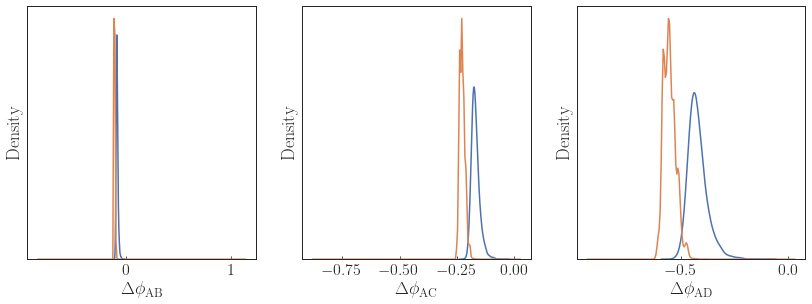

In [55]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=1/3.))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.kdeplot(unblind_pot(all_composite_samples_lint_1[:3][0], 0), ax=ax1, bw_method=smoothing)
sns.kdeplot(unblind_pot(all_composite_samples_lint_1[:3][1], 1), ax=ax2, bw_method=smoothing)
sns.kdeplot(unblind_pot(all_composite_samples_lint_1[:3][2], 2), ax=ax3, bw_method=smoothing)

sns.kdeplot(unblind_glee(glee_comp[:, 5], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax1, bw_method=smoothing)
sns.kdeplot(unblind_glee(glee_comp[:, 6], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax2, bw_method=smoothing)
sns.kdeplot(unblind_glee(glee_comp[:, 7], glee_comp[:, 1]), weights=glee_comp[:, 1], ax=ax3, bw_method=smoothing)


ax1.set_xlabel(r'$\Delta \phi_{\rm AB}$')
ax2.set_xlabel(r'$\Delta \phi_{\rm AC}$')
ax3.set_xlabel(r'$\Delta \phi_{\rm AD}$')


ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

# if blind:
#     w = 0.4
#     limit = [[-w, w]]*3 
# else:
#     p = 0.3
#     limit = [[mean_AB * (1-p)*time_delay2fermat_pot, mean_AB * (1+p)*time_delay2fermat_pot], 
#              [mean_AC * (1-p)*time_delay2fermat_pot, mean_AC * (1+p)*time_delay2fermat_pot], 
#              [mean_AD * (1-p)*time_delay2fermat_pot, mean_AD * (1+p)*time_delay2fermat_pot]]

# ax1.set_xlim(limit[0][0], limit[0][1])
# ax2.set_xlim(limit[1][0], limit[1][1])
# ax3.set_xlim(limit[2][0], limit[2][1]);

if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/comp_potential_difference_kappa_ext.pdf', bbox_inches='tight')

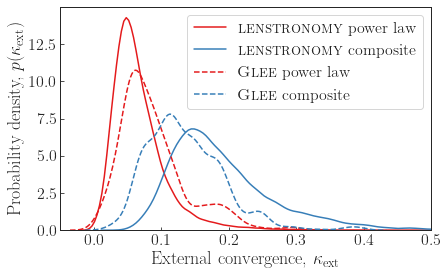

In [73]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))
ax = fig.add_subplot(111)

# sns.kdeplot(pdf_draw_pl, ax=ax, label='lenstronomy', color=pf.cb_green)
# sns.kdeplot(pdf_draw_comp, ax=ax, label='Composite', color=pf.cb_blue)

glee_kappa_ext_pl = np.random.choice(glee_potentials_pl[:, 9], 
                                     p=glee_potentials_pl[:, 1]/np.sum(glee_potentials_pl[:, 1]),
                                     size=1000
                                    )

glee_kappa_ext_comp = np.random.choice(glee_potentials_comp[:, 5], 
                                     p=glee_potentials_comp[:, 1]/np.sum(glee_potentials_comp[:, 1]),
                                     size=1000
                                    )

ax.set_xlabel(r'External convergence, $\kappa_{\rm ext}$')
ax.set_ylabel(r'Probability density, $p(\kappa_{\rm ext})$')
ax.set_xlim(-0.05, 0.5)
ax.legend()

sns.kdeplot(pdf_draw_pl, ax=ax, label=r'$\textsc{lenstronomy}$ power law', color=pf.cb_red)
sns.kdeplot(pdf_draw_comp, ax=ax, label=r'$\textsc{lenstronomy}$ composite', color=pf.cb_blue)

sns.kdeplot(glee_kappa_ext_pl, ax=ax, label=r'$\textsc{Glee}$ power law', color=pf.cb_red, ls='--')
sns.kdeplot(glee_kappa_ext_comp, ax=ax, label=r'$\textsc{Glee}$ composite', color=pf.cb_blue, ls='--')


ax.set_xlabel(r'External convergence, $\kappa_{\rm ext}$')
ax.set_ylabel(r'Probability density, $p(\kappa_{\rm ext})$')
ax.set_xlim(-0.05, 0.5)
ax.legend()

if save_fig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_kappa_ext.pdf', bbox_inches='tight')

    
# if save_fig:
#     fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_kappa_ext.pdf', bbox_inches='tight')